In [1]:
import numpy as np
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('x_range')
    plt.ylabel('Accuracy')
    plt.show()
def likehoodScore(proba,y):
    return np.sum(proba * y)/proba.shape[0]

def firstNScore(n, pred, y):
    backup = np.array(pred, copy =True)
    for r in range(pred.shape[0]):
        row = backup[r]
        s = np.sort(row)
        for c in range(pred.shape[1]):
            temp = backup[r][c]
            backup[r][c] = False
            for j in range(1,n+1):
                if temp == s[-j]:
                    backup[r][c] = True
                    break
    res = np.sum(np.logical_and(backup,y))/pred.shape[0]
    return res               

def oneHotDecode(self, X_sample):
    result=None
    fiPos = 0
    colIndex = 0
    while colIndex < X_sample.shape[1]:
        if fiPos < len(self.ohe.n_values_) and colIndex == self.ohe.feature_indices_[fiPos]:                
            start = self.ohe.feature_indices_[fiPos]
            end_ = start+ self.ohe.n_values_[fiPos]
            #print("start{} end{}".format(start,end_))
            classes = np.argmax(X_sample[:,start:end_],axis=1).reshape(X_sample.shape[0],1)
            if result is None:
                result = classes
            else:
                result=np.hstack([result,classes])
            colIndex = end_
            fiPos = fiPos +1
        else:
            if result is None:
                result = X_sample[:,colIndex:colIndex+1]
            else:
                result=np.hstack([result, X_sample[:,colIndex:colIndex+1]])
            colIndex = colIndex +1
        
    return result 
def convertToDate(dayStamps):
    res = [] 
    for v in dayStamps:
        res.append(datetime.datetime.fromtimestamp(v*24*60*60))
    return res

#TODO confusion matrix ,e.g. 100 - 90 % precision
def _precisionClassify(df,proba, wins, c =0 ):
    for indx, v in enumerate(proba):
        row = 0
        col = 0
        if wins[indx] == c:
            col = 0
        else:
            col =1
        if v <0.2:
            row =6 
        elif v < 0.3 and  v >=0.2:
            row =5 
        elif v < 0.4 and v >= 0.3:
            row = 4 
        elif v < 0.5 and v >= 0.4:
            row = 3 
        elif v < 0.6 and v >= 0.5:
            row = 2 
        elif v < 0.8 and v >= 0.6:
            row = 1
        df.iloc[row,col] = df.iloc[row,col]+1 
    df[df.columns[2]] = df[df.columns[0]] /(df[df.columns[1]] + df[df.columns[0]])
    return df
    

def precisionMatrix(proba, y):
    rowHeader = ['>80','60-80','50-60','40-50','30-40','20-30','<20']
    df = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['h_Correct', 'h_Wrong','h_Precent'])
    hproba = proba[:,0]
    wins = np.argmax(y,axis=1)
    df = _precisionClassify(df,hproba,wins)
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['d_Correct', 'd_Wrong','d_Precent'])
    dproba = proba[:,1]
    df = df.join(_precisionClassify(temp,dproba,wins,c=1))
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['a_Correct', 'a_Wrong','a_Precent'])
    aproba = proba[:,2]
    df = df.join(_precisionClassify(temp,aproba,wins,c=2))
    return df
       
from datetime import date, timedelta
def futureTest(mlp, X,y,numOfWeek = 10,verbose=False):
    decoded = oneHotDecode(c, X)
    dates = convertToDate(X[:,c.dateColumn])
    dates = [d - timedelta(days=2) for d in dates]    
    weeks  = [ v.isocalendar()[1] for v in dates]
    thisWeek = weeks[-1]
    start = -1
    last = X.shape[0]
    index = -1
    w = 0
    sum_proba =None 
    sum_y =None
    sum_train_proba=None
    sum_train_y=None
    while w < numOfWeek:
        if thisWeek != weeks[index]:
            start = X.shape[0] +index+1
            X_train = X[0:start, :]
            X_test = X[start:last,:]
            y_train = y[0:start,:]
            y_test = y[start:last,:]
            mlp.fit(X_train,y_train)
            decoded = oneHotDecode(c,X_test)
            home = np.array([c.inverseTeamMapping(decoded[:,0])]).reshape(X_test.shape[0],1)
            away = np.array([c.inverseTeamMapping(decoded[:,1])]).reshape(X_test.shape[0],1)
            stack = np.hstack([home,away])
            proba = mlp.predict_proba(X_test)
            train_proba =mlp.predict_proba(X_train)
            errorIndx = np.argmax(proba,axis=1) != np.argmax(y_test,axis=1)
            if sum_proba is None:
                sum_proba = proba
                sum_y = y_test
                sum_train_proba = train_proba
                sum_train_y = y_train
            else:
                sum_proba = np.vstack([sum_proba,proba])
                sum_y = np.vstack([sum_y,y_test])
                sum_train_proba = np.vstack([sum_train_proba, train_proba])
                sum_train_y= np.vstack([sum_train_y, y_train])
            if verbose == True:
                print("week{}".format(w))
                print("numOftest {} , score {}".format(X_test.shape[0],mlp.score(X_test,y_test)))
                print(np.hstack([stack[errorIndx],proba[errorIndx],y_test[errorIndx]]))
                print("first2 : {}",firstNScore(2,proba,y_test))
            last = start
            thisWeek = weeks[index]
            w = w+1
        index = index -1
        
    print("summary")
    print("score:")
    score = firstNScore(1,sum_proba,sum_y)
    print(score)
    print("2like")
    like2 = firstNScore(2,sum_proba,sum_y)
    print(precisionMatrix(sum_proba,sum_y))
    
    return firstNScore(1,sum_train_proba,sum_train_y), score, like2


In [63]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
class FootballDataHelper:
    def __init__ (self, recentNum=5):
        self.win_mapping = {'H':0, 'D':1,'A':2}
        self.recentNum = recentNum
        self.df = None
        self.teamsData={}
        #self.hiddensCount = 2
       
        
    def readFootBallData(self,filename): 
        df = pd.read_csv(filename)
        #df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        #df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

        #df= df.drop('Referee', 1)
        #self.team = df['HomeTeam'].drop_duplicates()
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
 
    def getTeam(self,dataFrame, teamName):       
        return dataFrame[(dataFrame["HomeTeam"] == teamName) | (dataFrame["AwayTeam"] == teamName)]
 
        
    def previousRecords(self,team, date , recentNum):
        prev = team[( team["Date"] < date)]
        
        if prev.shape[0] < recentNum :
            #print("less than min Num")
            return None
        else:
            return prev.iloc[-recentNum:]
    def readPredict (self, filename):
        df = pd.read_csv(filename)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

        return df
    
    
  
    def inverseTeamMapping (self, col):
        inverseMap ={}
        for name in self.teamsMap.keys():        
            inverseMap[self.teamsMap[name]] = name
        res =[]
        for idex, v in enumerate(col):
            res.append(inverseMap[v])
        return res

    def _getH6RecentMatches(self,x, X,teamName,recentNum):
        team = self.getTeam(X,teamName)
        prev = self.previousRecords(team,x['Date'],recentNum)
        if prev is None:
               return None
        prevHt=  prev['HomeTeam'].values
        prevAt=  prev['AwayTeam'].values   
        prevIsHome = []
        prevOther = []
        for i in range(recentNum):
            if prevHt[i] == teamName:
                prevIsHome.append(1)
                prevOther.append(prevAt[i])
            else:
                prevIsHome.append(0)
                prevOther.append(prevHt[i])
        wins = prev['FTR'].values       
        temp = np.array([prevIsHome,prev['FTHG'].values,prev['FTAG'].values,prev['HY'].values,prev['AY'].values,
                         prev['HR'].values,prev['AR'].values,prevOther,wins]).T

        return temp

    def readTeamMatch(self, teamName):
        df = pd.read_csv('teams/'+teamName+'.csv')
        df['1'] = pd.to_datetime(df['1'],yearfirst=True)
        df['1']= (pd.to_numeric(target['1'])/1e9/24/60/60)
        self.teamsData[teamName]=df.sort(['1'],ascending=[False]).values
    
    def commonMapping(self, X):
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        X['Referee']=X['Referee'].map(self.refereesMap).fillna(0)
        X['HTR'] = X['HTR'].map(self.win_mapping)
        X['FTR'] = X['FTR'].map(self.win_mapping)
        return X
    def initData(self, X, target,encode):
        X  = X.sort_values(by="Date")
        isInput = False
        if target is None:
            target =X      
        else:
            if self.ohe is None:
                raise Exception("Not yet get train data")
            isInput = True
            if encode == True:
                target = self.commonMapping(target)
        y=None
        if encode == True:    
            X =self.commonMapping(X)
            y = []
            for v in target['FTR']:
                y.append(range(3)==v)
        else:
            y = target['FTR'].values
        target_date = (pd.to_numeric(target['Date'])/1e9/24/60/60).values
        return isInput, X,y, target, target_date
   
    def aggregate(self,recents,nonExpand,isInput,encode):
        res =None
        if encode == True:
            if isInput==False:
                self.ohe = OneHotEncoder(categorical_features='all')
                self.ohe.fit(recents)
            res = self.ohe.transform(recents).toarray()
        else:
            res = np.array(recents)
        self.dateColumn = res.shape[1]
        res = np.hstack([res,nonExpand])
        return res
    def _extractFromPrevious(self, prev,teamName):
        homes =  prev['HomeTeam'].values
        ftr = prev['FTR'].values
        homeGoals = prev['FTHG'].values
        awayGoals = prev['FTAG'].values
        homeYellow = prev['HY'].values
        awayYellow = prev['AY'].values
        homeRed = prev['HR'].values
        awayRed =prev['AR'].values
        scored = 0
        conceded = 0
        wins = 0
        draw =0
        lose = 0
        yellowCards = 0
        redCards = 0
        for i in range(ftr.shape[0]):
            if homes[i] == teamName:
                if ftr[i] == 'H' or ftr[i] == 0:
                    wins = wins+1
                elif ftr[i] == 'A' or ftr[i] == 2:
                    lose = lose+1
                else:
                    draw = draw +1
                scored = scored + homeGoals[i]
                conceded = conceded + awayGoals[i]
                yellowCards = yellowCards + homeYellow[i]
                redCards = redCards + homeRed[i]
                
            else:
                if ftr[i] == 'A' or ftr[i] == 2:
                    wins = wins+1
                elif ftr[i] == 'H' or ftr[i] == 0:
                    lose = lose+1
                else:
                    draw = draw +1
                scored = scored + awayGoals[i]
                conceded = conceded + homeGoals[i]
                yellowCards = yellowCards + awayYellow[i]
                redCards = redCards + awayRed[i]
                              
        temp = np.array([wins,draw,lose,scored,conceded, yellowCards, redCards])
        return temp
    def _getH7RecentMatches(self,x, X,teamName,recentNum,isHome):
        team = self.getTeam(X,teamName)
        homeOrAway = None
        if isHome == True:
            homeOrAway = X[X['HomeTeam']==teamName]
        else:
            homeOrAway = X[X['AwayTeam']==teamName]
        prev = self.previousRecords(team,x['Date'],recentNum)
        prevHomeOrAway = self.previousRecords(homeOrAway,x['Date'],recentNum)
        if prev is None or prevHomeOrAway is None:
            return None
        res1= self._extractFromPrevious(prev,teamName)
       # res2= self._extractFromPrevious(prevHomeOrAway,teamName)
        
        return res1
    def getH7(self, recentNum, target=None,encode = True):
        #Simple recent win,draw, lose 
        isInput, X, y,target, target_date = self.initData(self.df,target,encode)
        resy=[]
        resx=[]
        print("start format")
        recents = []
        nonExpand =[]
        for i in range(target.shape[0]):
            
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            x = target.iloc[i]
            homeName = x['HomeTeam']
            awayName = x['AwayTeam']
            homeRecent = self._getH7RecentMatches(x,X,homeName, recentNum,True)
            awayRecent =self._getH7RecentMatches(x,X,awayName, recentNum,False)
            if homeRecent is None or awayRecent is None:
                   continue 
            #print(homeName)
           # print(homeRecent)
          #  print(awayName)
         #   print(awayRecent)
            #return
            referee = x['Referee']
            if recentNum == 0:
                recents.append(np.hstack([homeName,awayName,referee]))
                nonExpand.append(target_date[i])
            else:
                recents.append(np.hstack([homeName,awayName,referee]))
                nonExpand.append(np.hstack([target_date[i],homeRecent,awayRecent]))

            resy.append(y[i])
        res = self.aggregate(recents,nonExpand,isInput,encode)
        print("finish")
        sys.stdout.flush()
        return res, np.array(resy)

In [72]:
c = FootballDataHelper()
c.readFootBallData("E0_1112.csv")
c.readFootBallData("E0_1213.csv")
c.readFootBallData("E0_1314.csv")
c.readFootBallData("E0_1415.csv")
c.readFootBallData("E0 (1).csv")
print(c.teamsMap)

{'QPR': 4, 'Bolton': 15, 'Cardiff': 25, 'Newcastle': 3, 'Bournemouth': 28, 'Norwich': 16, 'Arsenal': 9, 'Wolves': 17, 'Man City': 8, 'Leicester': 26, 'Burnley': 27, 'Swansea': 14, 'Blackburn': 0, 'Chelsea': 11, 'Wigan': 5, 'Fulham': 1, 'Sunderland': 13, 'Crystal Palace': 23, 'Watford': 29, 'Stoke': 6, 'Southampton': 22, 'Tottenham': 19, 'Man United': 18, 'West Brom': 7, 'West Ham': 21, 'Aston Villa': 10, 'Everton': 12, 'Hull': 24, 'Reading': 20, 'Liverpool': 2}


In [73]:
X,y = c.getH7(5)


start format
 progress 1812finish


In [38]:
%matplotlib qt
def plotErrorDate(X_test, X_err, dateCol = 10):
    X_test_date =np.sort(X_test[:,c.dateColumn])
    X_date=[]
    y_date=[]
    for v in X_test_date:
        date = datetime.datetime.fromtimestamp(v*24*60*60)
        if len(X_date) ==0  or X_date[-1] != date:
            X_date.append(date)
            y_date.append(1)
        else:
            y_date[-1] = y_date[-1] +1
    plt.plot_date(X_date,y_date,xdate=True)
    X_err_d = np.sort(X_err[:,c.dateColumn])
    X_err_date=[]
    y_err_date = []
    for v in X_err_d:
        date = datetime.datetime.fromtimestamp(v*24*60*60)
        if len(X_err_date) ==0  or X_err_date[-1] != date:
            X_err_date.append(date)
            y_err_date.append(1)
        else:
            y_err_date[-1] = y_err_date[-1] +1
    plt.plot_date(X_err_date,y_err_date,xdate=True,color='red')
    plt.show()



In [77]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
g_hiddenNodes = int(40)
g_alpha = 35 
clf = SoftMaxMLPClassifier(hidden_layer_sizes=[g_hiddenNodes], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
              learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=1000,early_stopping = True,verbose = 3)
mlp = Pipeline([ ('scl', StandardScaler()),('clf', clf)])

In [ ]:
mlp.fit(X,y)
#res = mlp.predict(X_in)

In [78]:
print ("start learning")
sys.stdout.flush()
train_sizes, train_scores, test_scores = learning_curve(estimator=mlp, 
                       X=X, 
                      y=y, 
                      train_sizes=np.linspace(0.1, 1.0, 4), 
                      cv=4,
                     n_jobs=1,verbose=3)
print("finishing")   
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


print(test_mean)

start learning
[learning_curve] Training set sizes: [ 121  484  848 1212]
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.445545 -   0.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.460396 -   0.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.519802 -   1.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.495050 -   0.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.438119 -   0.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.438119 -   0.3s
[CV] no parameters to be set .........................................
[CV

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    9.4s finished


In [86]:
learningRes = np.vstack([train_sizes,train_mean,train_std,test_mean,test_std]).T


[ 121  484  848 1212]
[[  1.21000000e+02   4.17355372e-01   2.14717042e-02   4.43069307e-01
    6.77874452e-03]
 [  4.84000000e+02   4.49380165e-01   1.27782199e-02   4.46782178e-01
    1.02804751e-02]
 [  8.48000000e+02   5.49528302e-01   1.09040342e-02   5.14232673e-01
    1.70032570e-02]
 [  1.21200000e+03   5.52186469e-01   1.14084627e-02   5.10519802e-01
    2.95154456e-02]]


In [100]:
learningDf = pd.DataFrame(learningRes,columns=['size','train_mean','train_std','test_mean','test_std'])
print(learningDf)

   size  train_mean  train_std  test_mean  test_std
0   121    0.417355   0.021472   0.443069  0.006779
1   484    0.449380   0.012778   0.446782  0.010280
2   848    0.549528   0.010904   0.514233  0.017003
3  1212    0.552186   0.011408   0.510520  0.029515


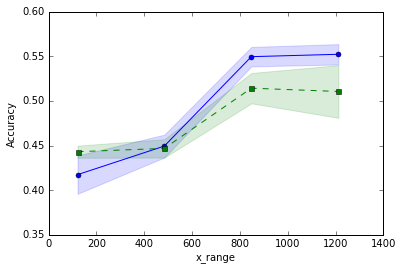

In [79]:
%matplotlib inline
plotCurve(train_mean,train_std,test_mean,test_std,train_sizes)


In [88]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate(mlp, X,y, fold = 10):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=fold,
                            random_state=1)

    scores = []
    train_scores=[]
    firstNScores = []
    for k, (train, test) in enumerate(kfold):

        mlp.fit(X[train], y[train])
        score = mlp.score(X[test], y[test])
        firstNScores.append(firstNScore(2, mlp.predict_proba(X[test]), y[test]))
        train_scores.append(mlp.score(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
        
        
    return train_scores,scores, firstNScores



Fold: 1, Class dist.: [626 352 434], Acc: 0.461
Fold: 2, Class dist.: [626 352 435], Acc: 0.448
Fold: 3, Class dist.: [626 352 435], Acc: 0.419
Fold: 4, Class dist.: [626 353 435], Acc: 0.446
Fold: 5, Class dist.: [627 353 435], Acc: 0.448
Fold: 6, Class dist.: [627 353 435], Acc: 0.348
Fold: 7, Class dist.: [627 353 435], Acc: 0.448
Fold: 8, Class dist.: [627 353 435], Acc: 0.393
lamda: 0, train: 1.0, test: 0.42626748280882143
Fold: 1, Class dist.: [626 352 434], Acc: 0.471
Fold: 2, Class dist.: [626 352 435], Acc: 0.498
Fold: 3, Class dist.: [626 352 435], Acc: 0.532
Fold: 4, Class dist.: [626 353 435], Acc: 0.550
Fold: 5, Class dist.: [627 353 435], Acc: 0.502
Fold: 6, Class dist.: [627 353 435], Acc: 0.453
Fold: 7, Class dist.: [627 353 435], Acc: 0.498
Fold: 8, Class dist.: [627 353 435], Acc: 0.498
lamda: 10, train: 0.6948433417738903, test: 0.49998732403179724
Fold: 1, Class dist.: [626 352 434], Acc: 0.495
Fold: 2, Class dist.: [626 352 435], Acc: 0.517
Fold: 3, Class dist.: [6

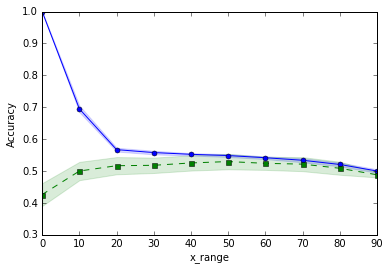

In [89]:

def lamda_test(mlp, X, y, lamdas):
    
    train_scores=[]
    test_scores=[]
    for lamda in lamdas:
        clf.set_params(alpha= lamda)
        train_s, test_s, firstNScores = crossValidate(mlp,X,y,fold=8)
      #  train_s, test_s, firstNScores =futureTest(mlp,X,y,numOfWeek=20) 
        train_scores.append(train_s)
        test_scores.append(test_s)
        print("lamda: {}, train: {}, test: {}".format(lamda, 
                    np.mean(train_s), np.mean(test_s)) )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plotCurve(train_mean,train_std,test_mean,test_std,lamdas)
    return np.array(train_scores),np.array(test_scores)

l_range = []
for i in range(0,10):
    l_range.append(10*i)
train_scores,test_scores = lamda_test(mlp,X,y,np.array(l_range))
#50

In [99]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
alphaRes = np.vstack([l_range,train_mean,train_std,test_mean,test_std]).T
alphaDf = pd.DataFrame(alphaRes,columns=['alpha','train_mean','train_std','test_mean','test_std'])
print(alphaDf)

   alpha  train_mean  train_std  test_mean  test_std
0      0    1.000000   0.000000   0.426267  0.035739
1     10    0.694843   0.010296   0.499987  0.028722
2     20    0.567097   0.005911   0.516723  0.027001
3     30    0.557901   0.005674   0.517934  0.024141
4     40    0.552423   0.003632   0.525363  0.023906
5     50    0.548532   0.004514   0.529697  0.024243
6     60    0.541725   0.004247   0.524125  0.020599
7     70    0.533770   0.006238   0.521637  0.022089
8     80    0.520598   0.005966   0.508654  0.020418
9     90    0.500088   0.005371   0.488239  0.008280


In [101]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testNodeSize(start ,end):
    node_range = range(start,end,10)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    for node in node_range:   
        print("start node:{}".format(node))
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[node], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores,first2 = crossValidate(mlp,X,y,fold=8)
      #  train_scores,test_scores , first2= futureTest(mlp, X,y,numOfWeek = 10)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        print("Node {}: train_mean {}  v.s. test_mean {}".format(node,np.mean(train_scores),np.mean(test_scores)))
    plotCurve(np.array(train_means),np.array(train_std),np.array(test_means),np.array(test_std),np.array(node_range))
    return node_range, train_means,train_std,test_means,test_std

start node:10
Fold: 1, Class dist.: [626 352 434], Acc: 0.510
Fold: 2, Class dist.: [626 352 435], Acc: 0.527
Fold: 3, Class dist.: [626 352 435], Acc: 0.547
Fold: 4, Class dist.: [626 353 435], Acc: 0.559
Fold: 5, Class dist.: [627 353 435], Acc: 0.542
Fold: 6, Class dist.: [627 353 435], Acc: 0.542
Fold: 7, Class dist.: [627 353 435], Acc: 0.537
Fold: 8, Class dist.: [627 353 435], Acc: 0.473
Node 10: train_mean 0.550388561727774  v.s. test_mean 0.5297036063703162
start node:20
Fold: 1, Class dist.: [626 352 434], Acc: 0.510
Fold: 2, Class dist.: [626 352 435], Acc: 0.522
Fold: 3, Class dist.: [626 352 435], Acc: 0.542
Fold: 4, Class dist.: [626 353 435], Acc: 0.559
Fold: 5, Class dist.: [627 353 435], Acc: 0.542
Fold: 6, Class dist.: [627 353 435], Acc: 0.542
Fold: 7, Class dist.: [627 353 435], Acc: 0.537
Fold: 8, Class dist.: [627 353 435], Acc: 0.473
Node 20: train_mean 0.551007874202588  v.s. test_mean 0.5284720792767201
start node:30
Fold: 1, Class dist.: [626 352 434], Acc: 0.

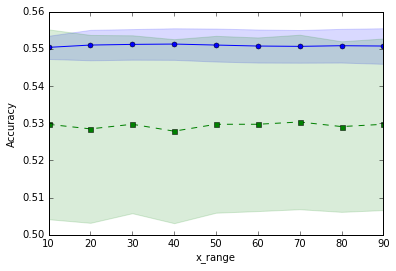

In [102]:
node_range, train_means,train_std,test_means,test_std=testNodeSize(10 ,X.shape[1] )

In [104]:
nodeRes = np.vstack([node_range,train_means,train_std,test_means,test_std]).T
nodeDf = pd.DataFrame(nodeRes,columns=['nodeNum','train_mean','train_std','test_mean','test_std'])
print(nodeDf)

   nodeNum  train_mean  train_std  test_mean  test_std
0       10    0.550389   0.003116   0.529704  0.025516
1       20    0.551008   0.004090   0.528472  0.025254
2       30    0.551185   0.004114   0.529716  0.023916
3       40    0.551273   0.004243   0.527856  0.024735
4       50    0.551008   0.004431   0.529710  0.023773
5       60    0.550743   0.004444   0.529713  0.023339
6       70    0.550655   0.004392   0.530329  0.023456
7       80    0.550831   0.004529   0.529091  0.022925
8       90    0.550743   0.004785   0.529707  0.023061


In [105]:
clf.set_params(alpha=g_alpha)
print(clf)
train_score, test_score, first2 = futureTest(mlp,X,y,numOfWeek = 20, verbose=True)      


SoftMaxMLPClassifier(activation='logistic', algorithm='l-bfgs', alpha=45,
           batch_size='auto', beta_1=0.9, beta_2=0.999,
           early_stopping=True, epsilon=1e-08, hidden_layer_sizes=[40],
           learning_rate='adaptive', learning_rate_init=0.01,
           max_iter=1000, momentum=0.9, nesterovs_momentum=True,
           power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=3, warm_start=False)
week0
numOftest 5 , score 0.6
[['Norwich' 'Man City' '0.25766189314506677' '0.24961687654081166'
  '0.4927212303141216' 'False' 'True' 'False']
 ['Stoke' 'Southampton' '0.6156529383357701' '0.183666243789743'
  '0.20068081787448688' 'False' 'False' 'True']]
first2 : {} 0.8
week1
numOftest 10 , score 0.4
[['Tottenham' 'Arsenal' '0.5522925566960117' '0.19683229528420484'
  '0.25087514801978333' 'False' 'True' 'False']
 ['Chelsea' 'Stoke' '0.7749974444392953' '0.1280245295325125'
  '0.09697802602819224' 'False' 'True' 'False']
 ['Ever

SyntaxError: 'return' outside function (<ipython-input-107-64672a10de46>, line 1)

In [108]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testRecentNum(start, end):
    recent_range = range(start,end)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    first2_mean=[]
    for recent in recent_range:
        print("start recent:{}".format(recent))
        X,y = c.getH7(recent)
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[60], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores, first2 = crossValidate(mlp,X,y,fold=10)
        #train_scores,test_scores, first2 = futureTest(mlp, X,y,numOfWeek = 15)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        first2_mean.append(np.mean(first2))
        print("recent {}: train_mean {}  v.s. test_mean {} , first2_mean {}".format(
                recent,np.mean(train_scores),np.mean(test_scores),np.mean(first2)))
    plotCurve(np.array(train_means),np.array(train_std),np.array(test_means),np.array(test_std),np.array(recent_range))
    return train_means,train_std,test_means,test_std,first2_mean



In [109]:
train_means,train_std,test_means,test_std,first2_mean=testRecentNum(1 ,15)

start recent:1
start format
 progress 639

KeyboardInterrupt: 

In [ ]:

proba = mlp.predict_proba(X_test)
precisionMatrix(proba,y_test)



In [ ]:
#future
mlp.fit(X,y)
inData = c.readPredict("future.csv")
print(inData)
X_in, y_in = c.getH6(5,target=inData)
res = mlp.predict(X_in)
proba= mlp.predict_proba(X_in)
print(mlp.score(X_in,y_in))
print (np.hstack([proba,y_in]))


In [ ]:
return
print(X.shape)

In [ ]:
X,y = c.getH7(5, encode=False)

In [ ]:
df = pd.DataFrame(np.hstack([X,y.reshape(y.shape[0],1)]))
df.columns = ['home','away','Referee','time','hw','hd','hl','hscore','hconcede','HY','HR',
'hw2','hd2','hl2','hscore2','hconcede2','HY2','HR2','aw','ad','al','ascore','aconcede','AH','AR',
              'aw2','ad2','al2','ascore2','aconcede2','AH2','AR2','y']
print(df)

In [ ]:

df.to_csv('h7.csv',index=False)